This notebooks aims to build several regressor along with comparing the metrices to predict the airbnb house price.


**Reading**
- [What In The World Are QQ Plots?](https://towardsdatascience.com/what-in-the-world-are-qq-plots-20d0e41dece1)
- [Kaggle Kernel](https://www.kaggle.com/jrw2200/smart-pricing-with-xgb-rfr-interpretations#Acknowledgements)

## 0: Loading all the modules and data

In [1]:
# Data pre-processing
import numpy as np 
import pandas as pd

# Viz.
import matplotlib
import missingno
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
matplotlib.rcParams['font.family'] = "Arial"

import plotly as py
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)

# Utils
import collections
import itertools
                   
# Scientific computing
import scipy.stats as stats
from scipy.stats import norm
from scipy.special import boxcox1p

import statsmodels
import statsmodels.api as sm

# ML Sklearn                   
from sklearn.svm import SVR
from sklearn.utils import resample
from sklearn.pipeline import Pipeline
from sklearn.kernel_ridge import KernelRidge
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import scale, StandardScaler, RobustScaler, OneHotEncoder
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, LinearRegression, ElasticNet,  HuberRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold, RandomizedSearchCV

# Other ML
from xgboost import XGBRegressor

#Model interpretation modules
import eli5
import lime
import lime.lime_tabular
import shap
shap.initjs() # Load JS visualization code to notebook

# Handling warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

/usr/local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning:

The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.

/usr/local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning:

The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.



In [2]:
# Loading the data
airbnb = pd.read_csv("data/AB_NYC_2019.csv")
airbnb.head(3)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365


In [3]:
# Shape
airbnb.shape

(48895, 16)

In [4]:
# Info
airbnb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [5]:
# Converting last_review to datetime
airbnb['last_review'] = pd.to_datetime(airbnb['last_review'], infer_datetime_format=True)

## 1: Pre-processing and EDA

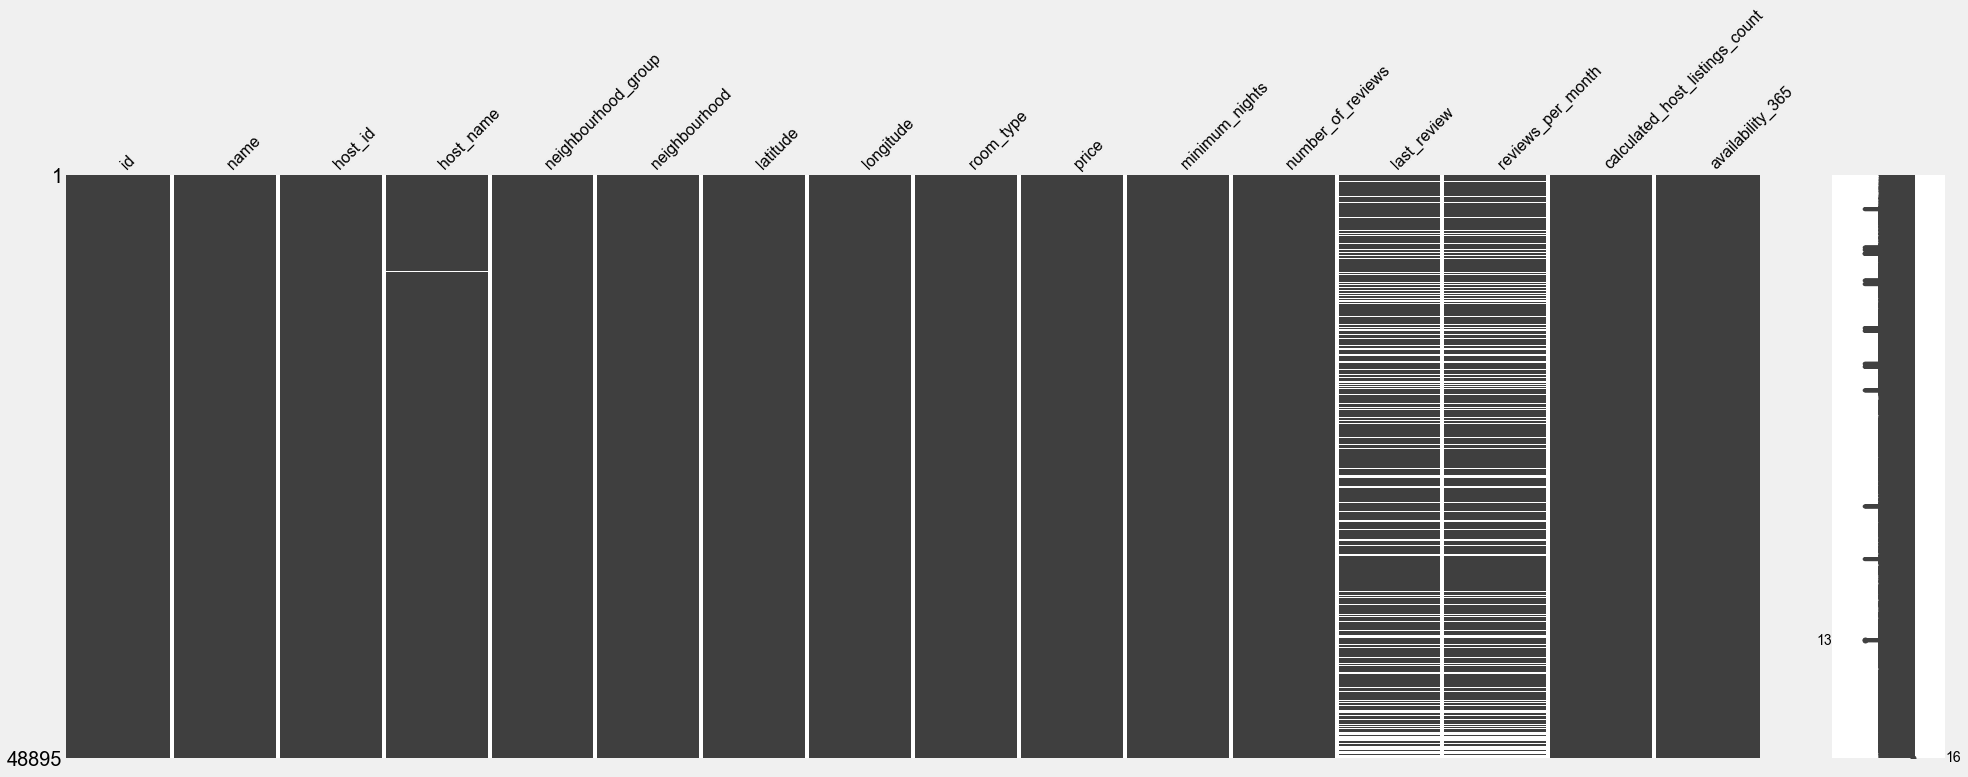

In [6]:
# Viewing all the missing values
missingno.matrix(airbnb, figsize=(30,10))

In [7]:
# Getting all the percent and count of missing values
def get_missing_count(data):
    total = data.isnull().sum().sort_values(ascending=False)
    percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total','Percent'], sort=False).sort_values('Total', ascending=False)
    return missing_data

In [8]:
get_missing_count(airbnb)

,Total,Percent
reviews_per_month,10052,0.205583
last_review,10052,0.205583
host_name,21,0.000429
name,16,0.000327
availability_365,0,0.000000
calculated_host_listings_count,0,0.000000
number_of_reviews,0,0.000000
minimum_nights,0,0.000000
price,0,0.000000
room_type,0,0.000000


In [9]:
# Information without any use
airbnb.drop(['name', 'host_name'], axis=1, inplace=True)

reviews_per_month is 0 at 10052 rows, which indicate no review. Hence, filling it with 0

In [10]:
airbnb['reviews_per_month'] = airbnb['reviews_per_month'].fillna(0)

In [11]:
# Filling last_review to remove all the empty values
earliest = min(airbnb['last_review'])
airbnb['last_review'] = airbnb['last_review'].fillna(earliest)
airbnb['last_review'] = airbnb['last_review'].apply(lambda x: x.toordinal() - earliest.toordinal()) # Finding the number of days

In [12]:
get_missing_count(airbnb)

,Total,Percent
availability_365,0,0.0
calculated_host_listings_count,0,0.0
reviews_per_month,0,0.0
last_review,0,0.0
number_of_reviews,0,0.0
minimum_nights,0,0.0
price,0,0.0
room_type,0,0.0
longitude,0,0.0
latitude,0,0.0


Now we have no missing values

### Transforming the target variable
Target has a highly skewed distribution. This can cause problems for machine learning algorithms such as linear regression. A log transformation and removal of outliers makes the distribution look much closer to normal.

In [13]:
def visualise_skewness(column):
    fig, axes = plt.subplots(1,3, figsize=(21,4))
    sns.distplot(column, ax=axes[0])
    sns.distplot(np.log1p(column), ax=axes[1])
    axes[1].set_xlabel('log(1+price)')
    sm.qqplot(np.log1p(column), stats.norm, fit=True, line='45', ax=axes[2]);

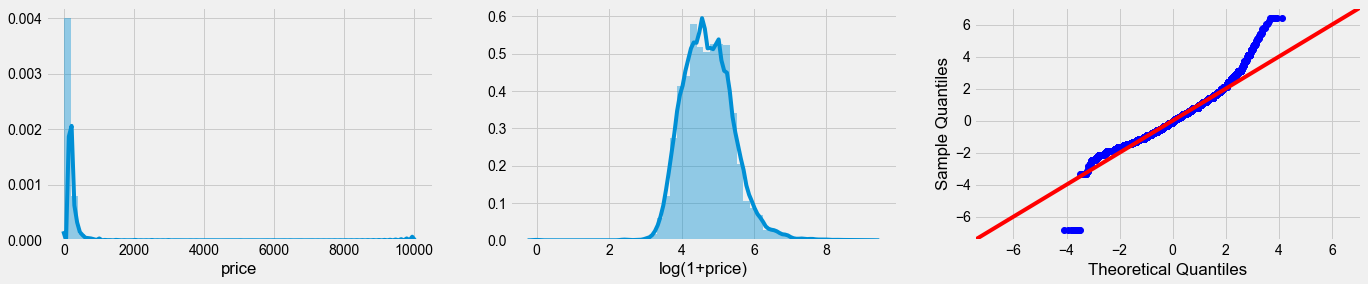

In [14]:
# Checking the distribution of the price
visualise_skewness(airbnb['price'])

Looking at the log(1+price) chart we can see that majority of prices lie in the range 3 to 8. Hence, only picking rows 3 to 8 to avoid any outliers

In [15]:
airbnb = airbnb[(np.log1p(airbnb['price']) > 3) & (np.log1p(airbnb['price']) < 8)]

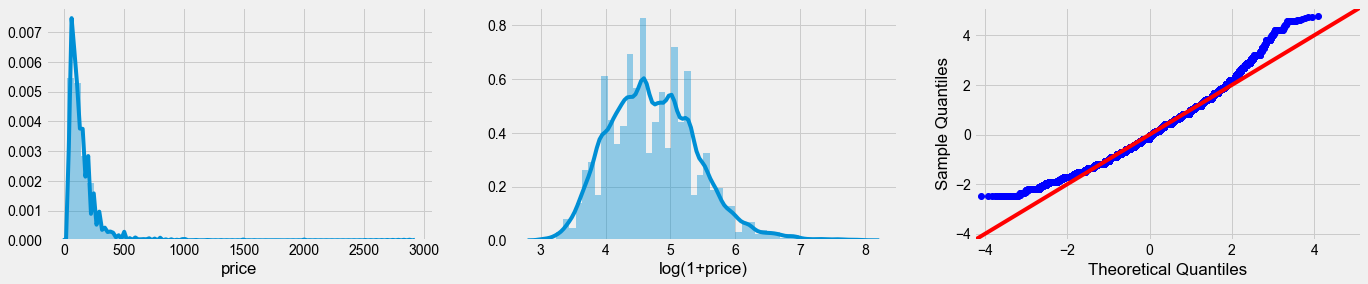

In [16]:
# Checking the distribution of the price post filtering
visualise_skewness(airbnb['price'])

### Transforming and checking the distribution of dependent variables

In [17]:
# Listing all the columns
airbnb.columns

Index(['id', 'host_id', 'neighbourhood_group', 'neighbourhood', 'latitude',
       'longitude', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'last_review', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365'],
      dtype='object')

**id, host_id**

Since these two dependent attributes are not necessary to make a prediction, dropping them.

In [18]:
airbnb.drop(['id', 'host_id'], axis=1, inplace=True)

**neighbourhood_group**

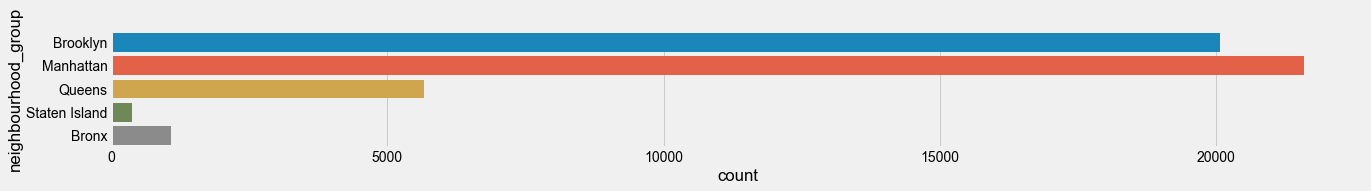

In [19]:
plt.figure(figsize=(20, 2))
sns.countplot(y="neighbourhood_group", data=airbnb);

**latitude and longitude**

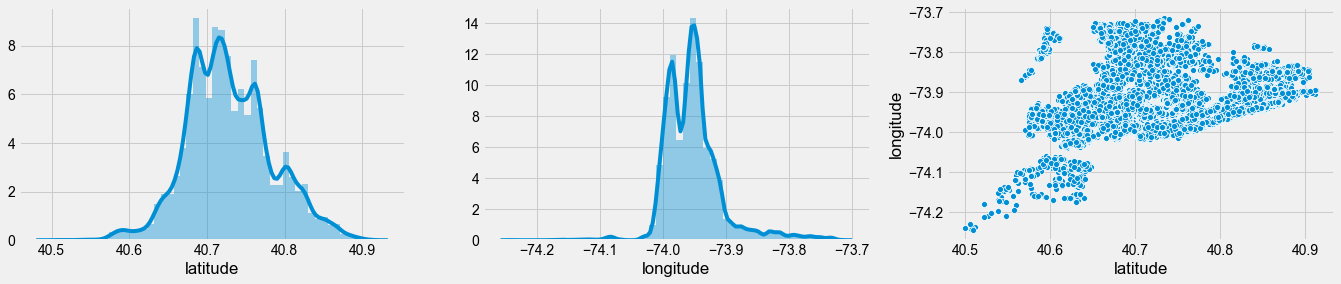

In [20]:
fig, axes = plt.subplots(1,3, figsize=(21,4))
sns.distplot(airbnb['latitude'], ax=axes[0])
sns.distplot(airbnb['longitude'], ax=axes[1])
sns.scatterplot(x=airbnb['latitude'], y=airbnb['longitude'])

**Room type**

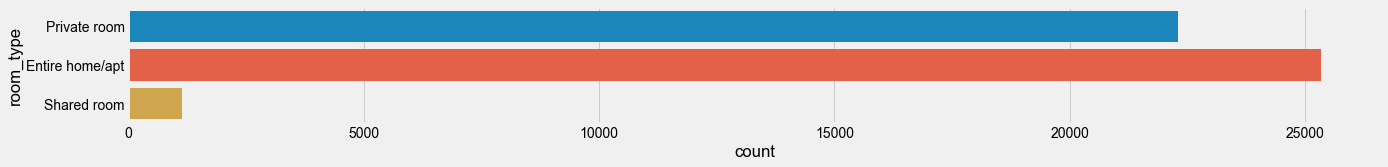

In [21]:
plt.figure(figsize=(20, 2))
sns.countplot(y="room_type", data=airbnb);

**Minimum nights**

Text(0, 0.5, 'count')

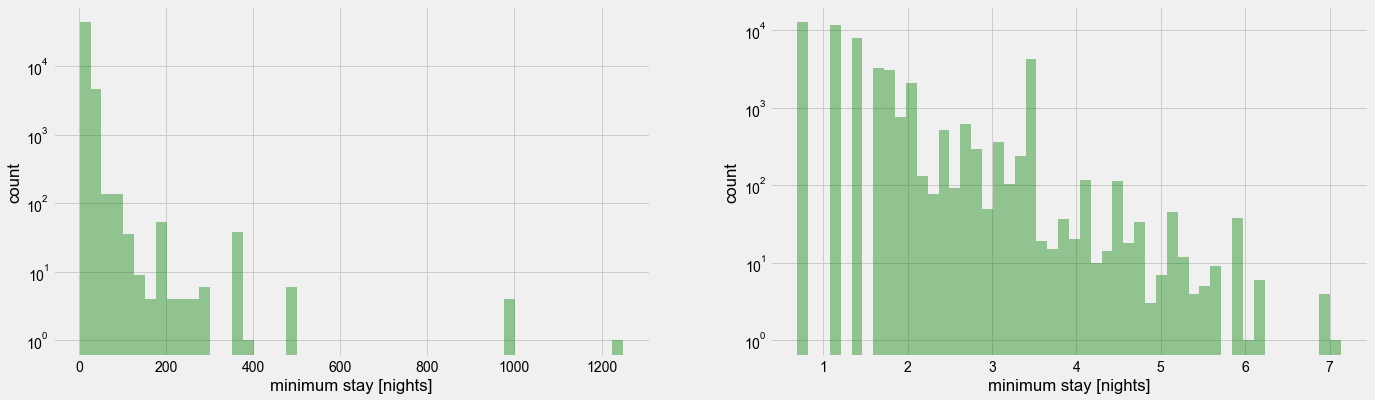

In [22]:
fig, axes = plt.subplots(1,2, figsize=(21, 6))

sns.distplot(airbnb['minimum_nights'], rug=False, kde=False, color="green", ax=axes[0])
axes[0].set_yscale('log')
axes[0].set_xlabel('minimum stay [nights]')
axes[0].set_ylabel('count')

sns.distplot(np.log1p(airbnb['minimum_nights']), rug=False, kde=False, color="green", ax=axes[1])
axes[1].set_yscale('log')
axes[1].set_xlabel('minimum stay [nights]')
axes[1].set_ylabel('count')


**reviews per month**

Text(0.5, 0, 'ln(reviews_per_month)')

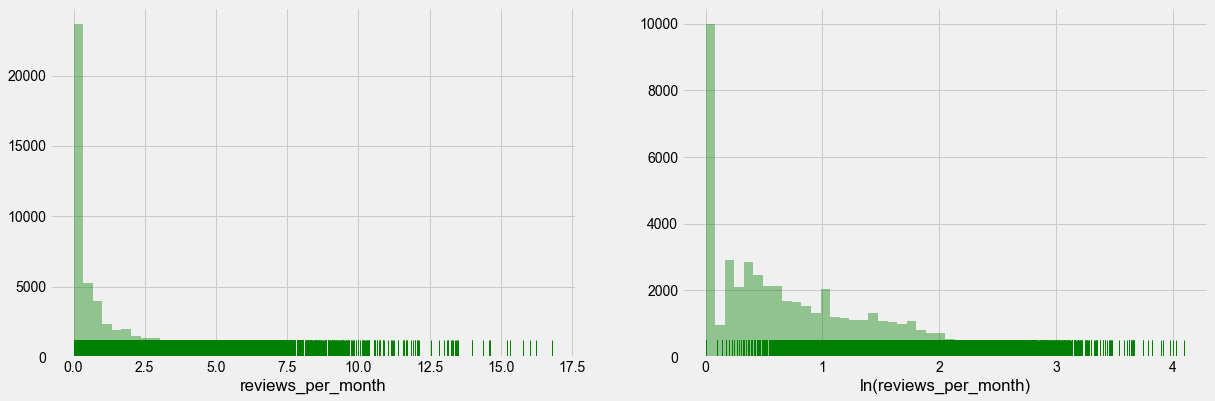

In [23]:
fig, axes = plt.subplots(1,2,figsize=(18.5, 6))

sns.distplot(airbnb[airbnb['reviews_per_month'] < 17.5]['reviews_per_month'], rug=True, kde=False, color="green", ax=axes[0])
sns.distplot(np.sqrt(airbnb[airbnb['reviews_per_month'] < 17.5]['reviews_per_month']), rug=True, kde=False, color="green", ax=axes[1])
axes[1].set_xlabel('ln(reviews_per_month)')

**Availability 365**

(0.0, 365.0)

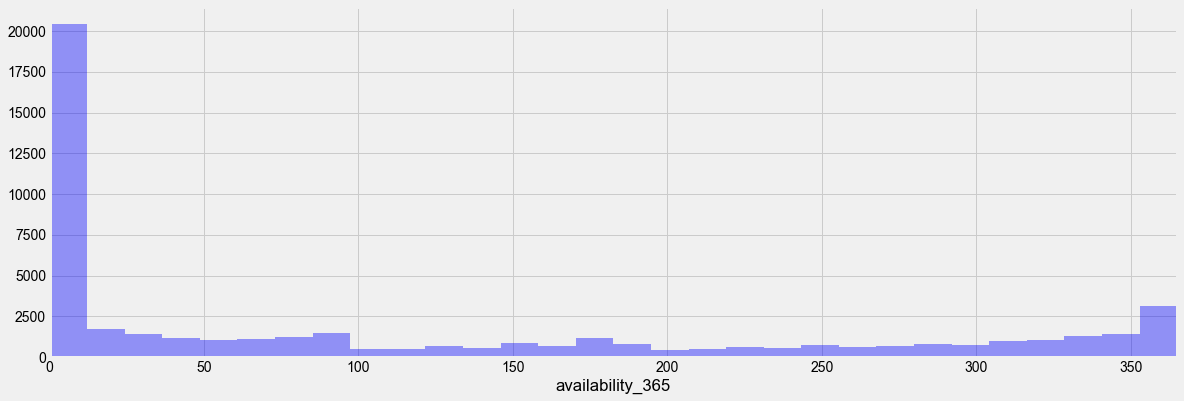

In [24]:
fig, axes = plt.subplots(1, 1, figsize=(18, 6))
sns.distplot(airbnb['availability_365'], rug=False, kde=False, color="blue", ax=axes)
axes.set_xlabel('availability_365')
axes.set_xlim(0, 365)

### Feature Engineering

In [25]:
# Adding a few more boolean values
airbnb['all_year_avail'] = airbnb['availability_365']>353
airbnb['low_avail'] = airbnb['availability_365']< 12
airbnb['no_reviews'] = airbnb['reviews_per_month']==0

In [26]:
airbnb.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,all_year_avail,low_avail,no_reviews
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2762,0.21,6,365,True,False,False
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2976,0.38,2,355,True,False,False
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,0,0.00,1,365,True,False,True
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,3021,4.64,1,194,False,False,False
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2793,0.10,1,0,False,True,False


## Bivariate correlations

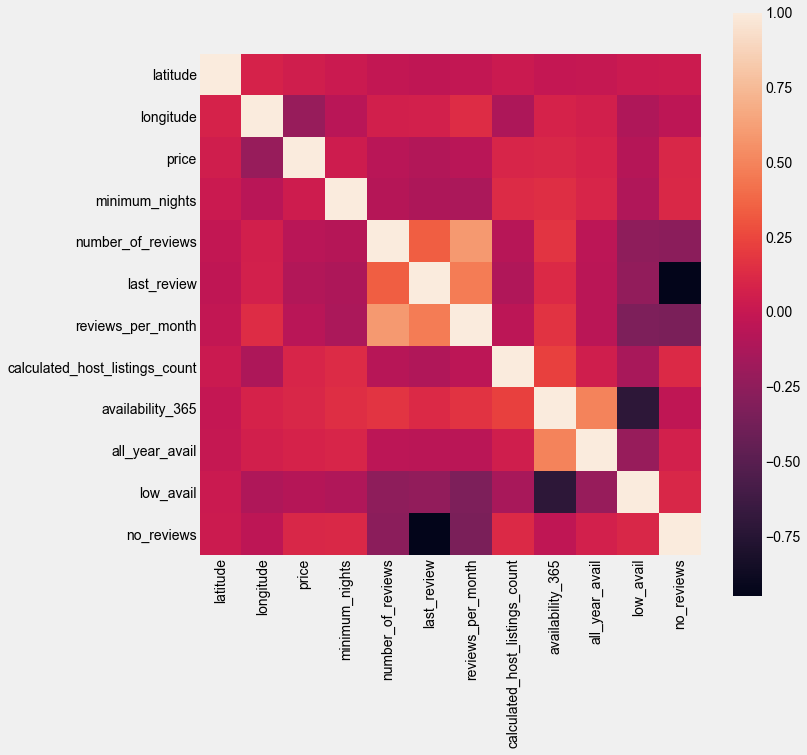

In [27]:
corrmatrix = airbnb.corr()

plt.figure(figsize=(10,10))
sns.heatmap(corrmatrix, vmax=1, square=True)
sns.set(font_scale=0.8)

### Encoding categorical features

In [28]:
# Fetching the categorical features
categorical_features = airbnb.select_dtypes(include=['object'])

In [29]:
categorical_features.columns

Index(['neighbourhood_group', 'neighbourhood', 'room_type'], dtype='object')

In [30]:
# One Hot Encoding categorial features
categorical_features_one_hot = pd.get_dummies(categorical_features)

### Saving the processed data for future use

In [31]:
# Separating the numerical, target feature and categorical features

numerical_features = airbnb.select_dtypes(exclude=['object'])
y = numerical_features.price
numerical_features.drop(['price'], axis=1, inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [32]:
# Creating a np and pd concat
X = np.concatenate((numerical_features, categorical_features_one_hot), axis=1)
X_df = pd.concat([numerical_features, categorical_features_one_hot], axis=1)

In [33]:
# Saving the processed data for future use
processed_data = pd.concat([X_df, y], axis = 1)
processed_data.to_csv('data/NYC_Airbnb_Processed.dat')

### Train test split

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

### Rescale the design matrix
Rescaling with RobustScaler() so that each predictor has zero mean and unit variance. This helps the convergence of machine learning algorithms such as linear regression.

In [35]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

## 2: Models

### 2.1 Cross Validation Routine

In [36]:
n_folds = 5

# Calculate squared loss
def rmse_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state = 91).get_n_splits(numerical_features)
    return cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=kf)

def rmse_lv_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state = 91).get_n_splits(numerical_features)
    return cross_val_score(model, Xlv_train, y_train, scoring='neg_mean_squared_error', cv=kf)

In [37]:
# Scoring basic models (no parameter tuning)
for model in [LinearRegression, Ridge, Lasso, ElasticNet, RandomForestRegressor, XGBRegressor, HuberRegressor]:
    if model == XGBRegressor:
        cv_res = rmse_cv(XGBRegressor(objective='reg:squarederror'))
    else:
        cv_res = rmse_cv(model())
        print('{}: mean: {:.5f} std: +/- {:5f}'.format(model.__name__, -cv_res.mean(), cv_res.std()))

LinearRegression: mean: 2206771033919007488.00000 std: +/- 4070411202842376704.000000
Ridge: mean: 17148.16380 std: +/- 2035.944587
Lasso: mean: 17783.70515 std: +/- 2089.893656
ElasticNet: mean: 19143.08293 std: +/- 2243.637142
RandomForestRegressor: mean: 16399.38084 std: +/- 1816.384053


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


HuberRegressor: mean: 18485.70716 std: +/- 2283.492084


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


### 2.2 Ridge Regression(More to be done)

In [38]:
alphas1 = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75] 
cv_ridge1 = [-rmse_cv(Ridge(alpha = alpha)).mean() for alpha in alphas1]

In [39]:
alphas2 = [0.5*i for i in range(4,12)]
cv_ridge2 = [-rmse_cv(Ridge(alpha = alpha)).mean() for alpha in alphas2]

In [40]:
cv_ridge1 = pd.Series(cv_ridge1, index = alphas1) 
cv_ridge2 = pd.Series(cv_ridge2, index = alphas2)

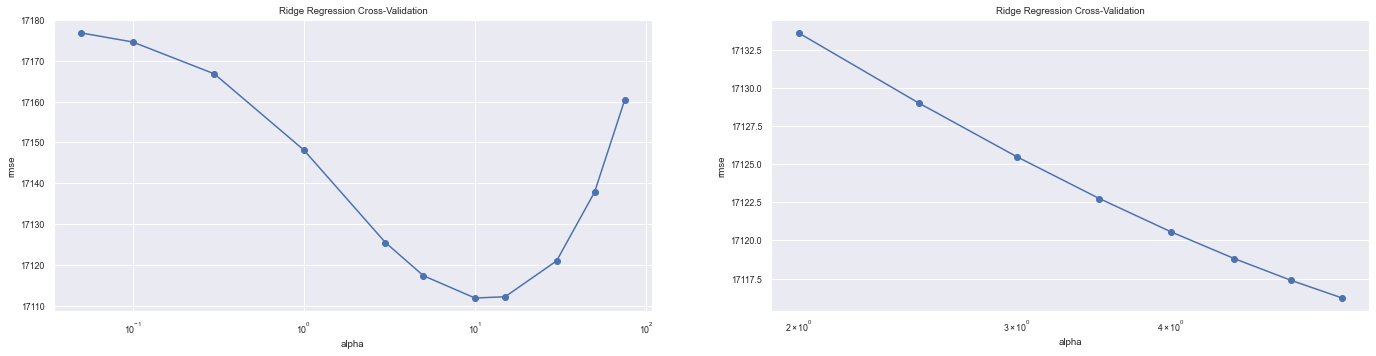

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(21, 5))
for i, cv_r in enumerate([cv_ridge1, cv_ridge2]):
    cv_r.plot(title = "Ridge Regression Cross-Validation", style='-o', ax = axes[i]) 
    axes[i].set_xlabel("alpha") 
    axes[i].set_ylabel("rmse")
    axes[i].set_xscale('log')

In [44]:
# Best Ridge Regression model

best_alpha = alphas2[np.argmin(cv_ridge2.values)]
RR_CV_best = -rmse_cv(Ridge(alpha = best_alpha))
RR = Ridge(alpha = best_alpha) 
RR.fit(X_train, y_train) 
y_train_RR = RR.predict(X_train)
y_test_RR = RR.predict(X_test)
ridge_results = pd.DataFrame({'algorithm':['Ridge Regression'],
            'CV error': RR_CV_best.mean(), 
            'CV std': RR_CV_best.std(),
            'training error': [mean_squared_error(y_train, y_train_RR)],
            'test error': [mean_squared_error(y_test_RR, y_test_RR)],
            'training_r2_score': [r2_score(y_train, y_train_RR)],
            'test_r2_score': [r2_score(y_test, y_test_RR)]})
ridge_results

,algorithm,CV error,CV std,training error,test error,training_r2_score,test_r2_score
0,Ridge Regression,17116.222763,2030.895494,16900.988353,0.0,0.262875,0.259519


In [45]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=X_df.columns, class_names=['price'], verbose=True, mode='regression')

In [47]:
i=25
exp = explainer.explain_instance(X_test[i], RR.predict, num_features=5)
item = pd.DataFrame(scaler.inverse_transform(X_test[i].reshape(1,-1))[0], index=X_df.columns)
item.loc['minimum_nights'] = np.expm1(item.loc['minimum_nights'])
item.loc['true_price'] = np.exp(y_test.iloc[i])
item.loc['predicted_price'] = np.exp(exp.local_pred)
item[(item.select_dtypes(include=['number']) != 0).any(1)]

Intercept 221.72082396593856
Prediction_local [222.33947755]
Right: 236.09620188879364


,0
latitude,4.072354e+01
longitude,-7.398295e+01
minimum_nights,1.908554e+01
number_of_reviews,3.000000e+01
last_review,3.003000e+03
reviews_per_month,2.800000e-01
calculated_host_listings_count,1.000000e+00
availability_365,2.480000e+02
neighbourhood_group_Manhattan,1.000000e+00
neighbourhood_East Village,1.000000e+00


In [48]:
exp.show_in_notebook(show_table=True)

### 2.3 Lasso Regression

In [ ]:
alphas = [0.0001, 0.001, 0.005,0.01, 0.05, 0.1, 0.3, 1] 
cv_lasso = [-rmse_cv(Lasso(alpha = alpha, max_iter=2000)).mean() for alpha in alphas]

Objective did not converge. You might want to increase the number of iterations. Duality gap: 169376569.90130422, tolerance: 69415.96907462923
Objective did not converge. You might want to increase the number of iterations. Duality gap: 207986025.30876175, tolerance: 74019.65752011791
Objective did not converge. You might want to increase the number of iterations. Duality gap: 216807664.3625419, tolerance: 73075.41825101855
Objective did not converge. You might want to increase the number of iterations. Duality gap: 177035525.00157934, tolerance: 71894.49208281351
Objective did not converge. You might want to increase the number of iterations. Duality gap: 190181645.03268543, tolerance: 69517.06443695155
Objective did not converge. You might want to increase the number of iterations. Duality gap: 5744917.964483261, tolerance: 69415.96907462923
Objective did not converge. You might want to increase the number of iterations. Duality gap: 6113715.652563453, tolerance: 74019.65752011791
Ob